Frekvenční analýza
============

vzorek signál (sinusovka s periodou 0.8 $\dot\ 2\pi \approx$ 5.) + šum (rovnoměrně rozdělená data)

In [3]:
%pylab inline 
from numpy.random import uniform
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 5]
x1=uniform(size=1024)
from numpy import arange,sin
b=arange(1024)
y1=sin(b/0.8)

Populating the interactive namespace from numpy and matplotlib


(0, 1024)

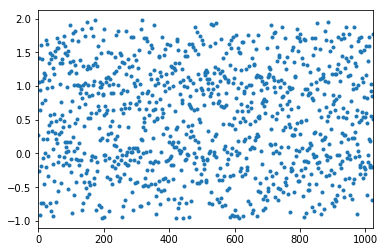

In [4]:
plot(b,y1+x1,'.')
xlim(0,1024)

fourierova transformace vzorku a čistého šumu

Text(0.5,0,'frekvence')

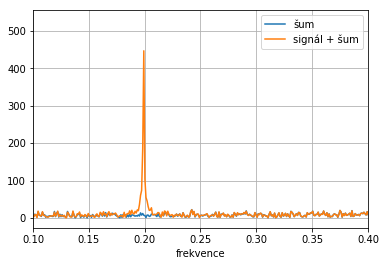

In [5]:
from matplotlib.pyplot import psd,plot
from numpy import fft
f1=fft.fft(x1) 
ft1=fft.fft(x1+y1)
gr1=plot(b[:512]/1024.,abs(f1[:512]),b[:512]/1024.,abs(ft1[:512]))
ax=gr1[0].axes
ax.set_xlim(0.1,0.4)
ax.grid(1)
legend([u"šum",u"signál + šum"])
xlabel("frekvence")
#a1=psd(x1)

In [6]:
from math import pi
pteor=0.8*2*pi
print("očekávaná frekvence %.5f Hz"%(1/pteor))

očekávaná frekvence 0.19894 Hz


### náhodná procházka (odbočka :)

tvorba *1/f* šumu 

11.705357747751327

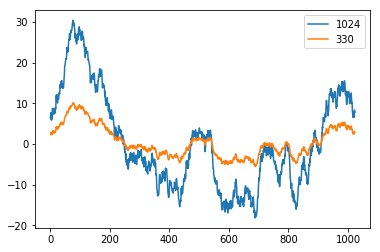

In [7]:
#b=arange(1024)
f1corr=f1.copy()
f1corr[1:]/=b[1:]/1024.
f2corr=f1.copy()
f2corr[1:]/=b[1:]/330.
#f1corr[0]=0
x1corr=fft.ifft(f1corr).real
x2corr=fft.ifft(f2corr).real
plot(b,x1corr,b,x2corr)
legend(['1024','330'])
x1corr.std()

In [8]:
# prevzorkovani sumu s 1/f spektrem
def refreq(samp,npt=1024):
    if npt==0: npt=samp.size
    f1=fft.fft(samp,npt)
    f1[1:]/=arange(1,npt)/float(npt)
    return fft.ifft(f1).real
t1=array([refreq(uniform(size=1024)).std() for i in range(32)])
t1.mean(),t1.std()

(8.501071228151247, 2.6852484456578587)

(array([-0.88073461,  7.52775264]), array([-0.95598662,  9.35864274]))

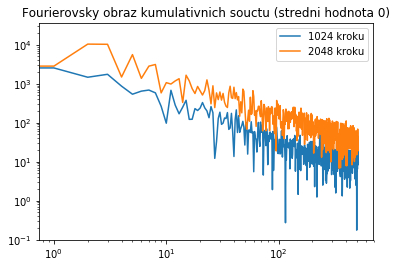

In [9]:
p=cumsum(uniform(-1,1,size=1024)) #nahodna prochazka
ffp=abs(fft.fft(p))
p2=cumsum(normal(0,1,size=2*1024))
ffp2=abs(fft.fft(p2))
loglog(ffp[:512])
loglog(ffp2[:512])
title("Fourierovsky obraz kumulativnich souctu (stredni hodnota 0)")
legend(["1024 kroku","2048 kroku"])
#prvni parametr odpovida linear. clenu v log_log skale (1/x zavislost)
polyfit(np.log(r_[1:512]),np.log(ffp[1:512]),1),polyfit(np.log(r_[1:512]),np.log(ffp2[1:512]),1)

jak narůstá rozptyl u náhodných procházek s rostoucí délkou

In [10]:
t2=array([[refreq(uniform(size=1024*s),npt=0).std() for i in range(32)] for s in range(1,8,2)])
t2.mean(1),t2.std(1)

(array([ 8.33235679, 13.51779185, 18.65406176, 21.83815166]),
 array([2.02525673, 4.25458694, 5.25363448, 6.70536026]))

In [11]:
t3=array([[cumsum(uniform(-1,1,size=1024*s)).std() for i in range(32)] for s in range(1,8,2)])
t3.mean(1),t3.std(1)

(array([ 7.10848356, 12.28328017, 16.86279871, 19.22755543]),
 array([2.76231263, 4.33618458, 7.99876803, 9.35023961]))

## Nerovnoměrné vzorkování

použití **Lomb-Scargle** algoritmu (periodogram) čili LSSA (least square spectral analysis)  
původní článek v [Astrophys.Journal](http://articles.adsabs.harvard.edu/full/1982ApJ...263..835S)  a pěkný ilustrativní rozbor Jakea Vanderplase
na [ArXivu](https://arxiv.org/abs/1703.09824)  
rychlá implementace v pythonu [zde](http://www.astropython.org/snippets/fast-lomb-scargle-algorithm32/)

klasický periodogram vychází z výpočtu 

$$P=\left|\frac{1}{N}\sum_{i=1}^N{g_i e^{-i\ 2 \pi \omega t_i}} \right|^2 =\\
= \frac{1}{N} \left[ \left( \sum_{i=1}^N{g_i \cos ( 2 \pi \omega t_i)}\right)^2 +  \left(\sum_{i=1}^N{g_i \sin (2 \pi \omega t_i)} \right)^2\right ]$$



u nerovnoměrného vzorkování není zajištěna ortogonalita členů s $\cos$ a $\sin$; Scargle navrhl zobecnění pomocí fázového posunu $\tau$ a normalizačních parametrů $A, B$ do tvaru
$$P=  \frac{A^2}{2} \left( \sum_{i=1}^N{g_i \cos (2 \pi \omega (t_i-\tau))}\right)^2 +  \frac{B^2}{2} \left(\sum_{i=1}^N{g_i \sin (2 \pi \omega (t_i-\tau))} \right)^2$$

Při volbě $A^2=1/\sum_{i=1}^N{ \cos^2 ( 2 \pi \omega (t_i-\tau))}$, $B^2=1/\sum_{i=1}^N{ \sin^2 ( 2 \pi \omega (t_i-\tau))}$ a
$$\tau = \frac{1}{4 \pi \omega} \arctan\left(\frac{\sum_{i=1}^N{ \sin ( 4 \pi \omega t_i)}}{\sum_{i=1}^N{ \cos ( 4 \pi \omega t_i)}} \right)$$ dostaneme periodogram, který není závislý na volbě počátku časové osy (vliv konkrétních vzorkovacích bodů $t_i$ odstraňuje právě volba $\tau$) a pro rovnoměrné vzorkování přechází do tvaru klasického periodogramu.

In [12]:
from scipy.signal import lombscargle
bsel=uniform(size=b.size)<0.7# náhodný výběr bodů

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\matplotlib\axes\_base.py:3449: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


Text(0.5,0,'frequence')

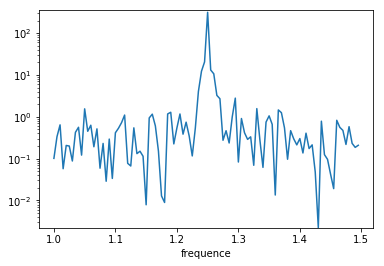

In [13]:
freqs=arange(1,1.5,0.005)
data=y1[bsel]+x1[bsel]
data-=data.mean()
data/=data.std()
pgram=lombscargle(b[bsel].astype('float'),data,freqs)
gr2=semilogy(freqs,pgram)[0]
gr2.axes.set_ylim(-20,350)
xlabel("frequence")

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\matplotlib\axes\_base.py:3449: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


Text(0.5,0,'frequence')

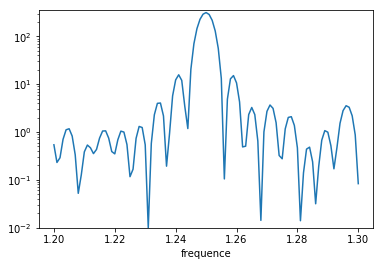

In [14]:
freqs=arange(1.2,1.3,0.001)
data=y1[bsel]+x1[bsel]
data-=data.mean()
data/=data.std()
pgram2=lombscargle(b[bsel].astype('float'),data,freqs)
gr2=semilogy(freqs,pgram2)[0]
gr2.axes.set_ylim(-20,350)
xlabel("frequence")

Text(0.5,0,'frequence')

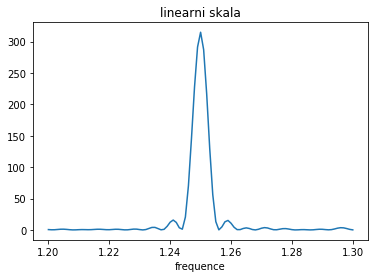

In [15]:
gr2=plot(freqs,pgram2)[0]
title("linearni skala")
xlabel("frequence")

rekonstrukce periody z maximální frekvence

In [16]:
1/freqs[pgram.argmax()]

0.8000000000000036

## vlastní konstrukce periodogramu

- pro každý bod dopočítáme fázi
- průběh fázové křivky zrekonstruujeme jako průměr přes interval `[t-win,t+win]`
- minimalizovaným kritériem je suma čtverců odchylek jednotlivých měření od rekonstruované křivky

In [17]:
def get_disp(peri,pos,data,ndiv=50,win=0.05,ret=1):
    #defaultne vrati sumu ctvercu rezidui bodu a stredni hodnoty
    nperi=(pos/peri).astype(int)
    phas=pos/peri-nperi
    #plot(phas,data,'.')
    phax=r_[:1:(ndiv+1)*1j]
    
    rep=[]
    cnt=[]
    for a in phax:
        sel=abs(phas-a)<win
        if a<win: sel[phas>1-win+a]=True
        if a>1-win: sel[phas<win-1+a]=True
        cnt.append(sum(sel))
        rep.append(sum(data[sel]))
    #plot(phax,array(rep)/array(cnt))
    cnt=array(cnt)
    cnt[cnt==0]=1
    if ret==4: return array(rep)/cnt
    if ret==3: return array(rep),cnt,phas
    if ret==2: return array(rep),cnt
    from scipy import interpolate
    prof=interpolate.interp1d(phax,array(rep)/cnt)
    chi2=sum((prof(phas)-data)**2)
    return chi2

#### ukázka "správné" periody a odchýlené o 0.01 (1.3%)

Text(0.5,0,'faze')

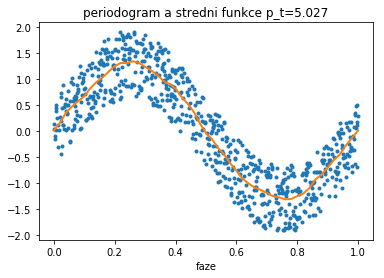

In [18]:
pgram=get_disp(pteor,b[bsel],data,ret=3)
ndiv=50
plot(pgram[2],data,'.')
plot(r_[:1:(ndiv+1)*1j],pgram[0]/pgram[1],lw=2)
title("periodogram a stredni funkce p_t=%.3f"%pteor)
xlabel("faze")

Text(0.5,0,'faze')

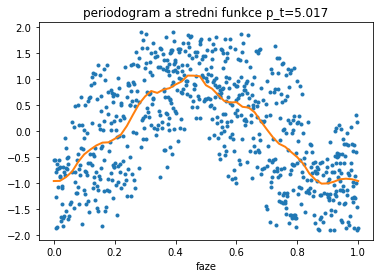

In [19]:
pgram=get_disp(pteor-0.01,b[bsel],data,ret=3)
ndiv=50
plot(pgram[2],data,'.')
plot(r_[:1:(ndiv+1)*1j],pgram[0]/pgram[1],lw=2)
title("periodogram a stredni funkce p_t=%.3f"%(pteor-0.01))
xlabel("faze")

aplikace na původní data (`y1` a šum `x1`)

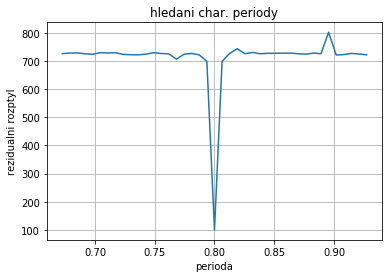

In [20]:
peris=r_[pteor-0.8:pteor+0.8:41j]
gmax=[get_disp(p,b[bsel],data) for p in peris]
plot(peris/2/pi,gmax)
xlabel("perioda")
ylabel("rezidualni rozptyl")
title("hledani char. periody")
grid()

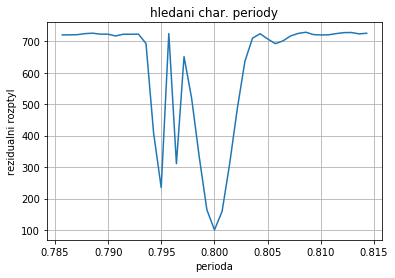

In [21]:
peris=r_[pteor-0.09:pteor+0.09:41j]
gmax=[get_disp(p,b[bsel],data) for p in peris]
plot(peris/2/pi,gmax)
xlabel("perioda")
ylabel("rezidualni rozptyl")
title("hledani char. periody")
grid()

Text(0.5,1,'amplituda prumerovaneho fazogramu (peak2peak)')

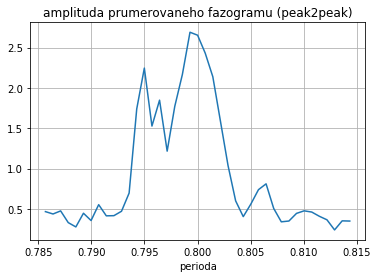

In [22]:
zp2p=lambda a:a.max()-a.min()
#zp2p(get_disp(p,b[bsel],data))
gamp=[zp2p(get_disp(p,b[bsel],data,ret=4)) for p in peris]
plot(peris/2/pi,gamp)
xlabel("perioda")
grid()
title("amplituda prumerovaneho fazogramu (peak2peak)")

### rekonstrukce dlouhoperiodické křivky

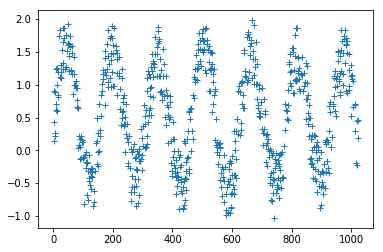

In [24]:
pteor2=24.8*2*pi
y2=sin(b/pteor2*2*pi)
y3=sin(b/pteor2*3*pi/2.)*0.1
data2=y2[bsel]+y3[bsel]+x1[bsel]
plot(b[bsel],data2,'+')

Text(0.5,0,'faze')

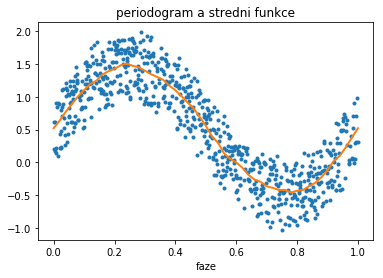

In [25]:
pgram=get_disp(pteor2,b[bsel],data2,ret=3)
ndiv=50
plot(pgram[2],data2,'.')
plot(r_[:1:(ndiv+1)*1j],pgram[0]/pgram[1],lw=2)
title("periodogram a stredni funkce")
xlabel("faze")

Text(0.5,0,'faze')

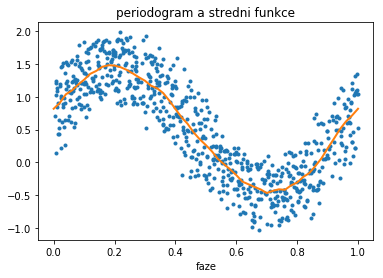

In [26]:
pgram=get_disp(pteor2+0.4*2*pi,b[bsel],data2,ret=3)
ndiv=50
plot(pgram[2],data2,'.')
plot(r_[:1:(ndiv+1)*1j],pgram[0]/pgram[1],lw=2)
title("periodogram a stredni funkce")
xlabel("faze")

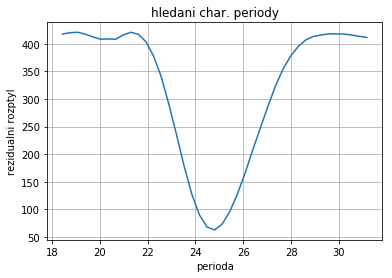

In [27]:
peris=r_[pteor2-40:pteor2+40:41j]
gmax=[get_disp(p,b[bsel],data2,ret=1) for p in peris]
plot(peris/2/pi,gmax)
xlabel("perioda")
ylabel("rezidualni rozptyl")
title("hledani char. periody")
grid()

**odhad nejistoty z profilu minima**  
(asymetrickou křivku prokládáme polynomem 4. stupně, z něj bereme 2. derivaci)

In [29]:
p0=np.argmin(gmax)
psel=peris[p0-5:p0+5]/2/pi
minprof=polyfit(psel,gmax[p0-5:p0+5],4)
minprof2=polyfit(psel,gmax[p0-5:p0+5],2)
mder=polyval(polyder(polyder(minprof)),psel).mean() #profil 2. derivace
#polyval(polyder(polyder(minprof)),psel)
aroot=roots(polyder(minprof)) # koreny 1. derivace
print("poloha minima a druhe derivace")
aroot.real[aroot.imag==0][0],mder,minprof2[0]

poloha minima a druhe derivace


(26.827228705602977, 92.10616888850709, 66.42082249832907)

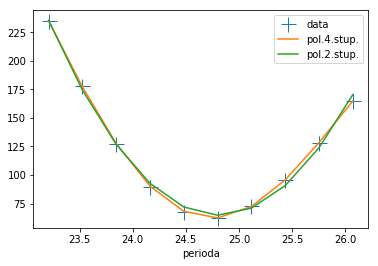

In [30]:
plot(psel,gmax[p0-5:p0+5],'+',ms=15)
plot(psel,polyval(minprof,psel))
plot(psel,polyval(minprof2,psel))
xlabel("perioda")
legend(['data','pol.4.stup.','pol.2.stup.'])

In [40]:
# srovnávací test s prostou sinusovkou (bez y3)
gmax=[get_disp(p,b[bsel],x1[bsel]+y2[bsel]) for p in peris]
min2prof=polyfit(psel,gmax[p0-5:p0+5],4)
min2prof2=polyfit(psel,gmax[p0-5:p0+5],2)
mder2=polyval(polyder(polyder(min2prof)),psel).mean()
aroot=roots(polyder(min2prof))

aroot.real[aroot.imag==0][0],mder,mder2,min2prof2[0]

poloha minima a druhe derivace


(26.653508764910516,
 77.610569374848268,
 79.353630977398282,
 65.501638513523773)

In [59]:
def phas_test(yval):
    bsel=uniform(size=b.size)<0.7
    gmax=[get_disp(p,b[bsel],uniform(size=sum(bsel))+yval[bsel]) for p in peris]
    aroot=roots(polyder(polyfit(psel,gmax[p0-5:p0+5],4)))
    return aroot.real[aroot.imag==0][0]
btot=np.array([phas_test(y2+y3) for i in range(200)]).T
2*pi*btot.mean()

168.87781149871722

In [60]:
2*pi*btot.std()

4.08767422078702

#### srovnání s FFT 
zpět pro měření s rovnoměrným vzorkováním

ocekavana hodnota a perioda z polohy maxima


(155.82299561805374, 146.28571428571428)

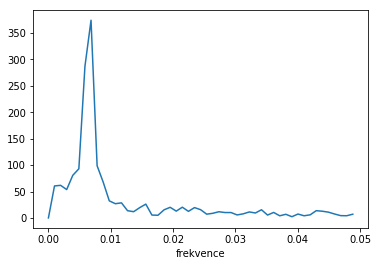

In [38]:
subias=(x1+y2).mean()
ft3=fft.fft(x1+y2-subias)
gr3=plot(b[:51]/1024.,abs(ft3[:51]))
print("ocekavana hodnota a perioda z polohy maxima")
xlabel("frekvence")
pteor2, 1/(b[5:51][argmax(abs(ft3[5:51]))]/1024.)

In [48]:
def four_test(yval):
    ft3=fft.fft(uniform(size=1024)+yval)
    mpos=3+argmax(abs(ft3[3:51]))
    if mpos<3:mpos=3
    ids=np.polyfit(r_[mpos-3:mpos+4],abs(ft3[:51])[mpos-3:mpos+4],2)
    return mpos,-ids[1]/2/ids[0]/1024.
ztot,atot=np.array([four_test(y2+y3) for i in range(200)]).T

In [61]:
1/atot.mean(),atot.std()/atot.mean()**2

(152.6936427752117, 0.6026768565257838)

In [54]:
1/atot.mean()/2/pi

24.301948026383016